# 👀 Overview

ImageNet is a pivotal dataset in the field of computer vision, comprising millions of annotated images categorized into thousands of classes. It serves as a benchmark for training and evaluating deep learning models, with architectures like AlexNet, VGG, GoogLeNet, ResNet, and MobileNet commonly used for this purpose. ImageNet's hierarchical structure facilitates organization and exploration of its vast array of object categories. Through challenges like the ImageNet Large Scale Visual Recognition Challenge (ILSVRC), researchers compete to achieve the highest accuracy in tasks such as image classification, object detection, and image segmentation. Overall, ImageNet continues to drive innovation and advancement in computer vision research, providing a foundational resource for developing state-of-the-art models and techniques. 

Read more about ImageNet on [Link](https://image-net.org/static_files/papers/imagenet_cvpr09.pdf).

**Data Preparation:** The Indian Sign Language dataset is obtained from Kaggle and partitioned into training, validation, and test sets with an 80%, 10%, 10% split. Each set contains images resized to a standard size and categorized into folders.

**Model Build:** A MobileNet architecture pre-trained on ImageNet is utilized as the base model. Custom classification layers are added on top of the MobileNet base, and all but the last 23 layers are frozen for fine-tuning on the sign language dataset.

**Kernel/Notebook Details:** The code is implemented in a Jupyter notebook environment using TensorFlow and Keras libraries. It includes data loading, data preprocessing, model building, training, evaluation, and visualization steps. The notebook is optimized for Kaggle's infrastructure, allowing efficient computation and sharing of results.


# 🔍 Load Libraries

In [1]:
import warnings

warnings.simplefilter(action ='ignore', category=FutureWarning)

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import os
import PIL
import shutil
import random
import glob
import itertools

%matplotlib inline

2024-07-09 14:13:35.947997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 14:13:35.948172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 14:13:36.108521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 📂 Load Data

In [2]:
# Define the path to the main directory
Indian_dir = '/kaggle/input/indian-sign-language-isl/Indian/'

# Count files in subdirectories
def count_images_in_folders(directory):
    folders = os.listdir(directory)
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images_count = len(os.listdir(folder_path))
            print(f"Folder: {folder}, Images Count: {images_count}")

# Print files in subdirectories
# print("Indian DataSet:")
# count_images_in_folders(Indian_dir)

# 🧹 Data Preparation

#### For fast computation dividing entire dataset into Train, Valid, Test (80%, 10%, 10%).

In [3]:
# Define destination directories
train_dir = "/kaggle/working/training_set"
valid_dir = "/kaggle/working/validation_set"
test_dir = "/kaggle/working/test_set"

# Create all directories if it does not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [4]:
# Function to copy files
def copy_files(src_dir, dst_dir, category, num_files):
    os.makedirs(os.path.join(dst_dir, category), exist_ok=True)
    files = os.listdir(os.path.join(src_dir, category))
    num_files_to_copy = min(num_files, len(files))
    files_to_copy = files[:num_files_to_copy]
    for file in files_to_copy:
        src_path = os.path.join(src_dir, category, file)
        dst_path = os.path.join(dst_dir, category, file)
        shutil.copy(src_path, dst_path)

# Define the number of images for each category in training, validation, and test sets
num_train_images = 80
num_valid_images = 10
num_test_images = 10

# Iterate through each subfolder and copy files to training, validation, and test sets
for category in os.listdir(Indian_dir):
    if os.path.isdir(os.path.join(Indian_dir, category)):
        copy_files(Indian_dir, train_dir, category, num_train_images)
        copy_files(Indian_dir, valid_dir, category, num_valid_images)
        copy_files(Indian_dir, test_dir, category, num_test_images)
        
# Print files in subdirectories
# print("Train Set:")
# count_images_in_folders(train_dir)

# print("\nTest Set:")
# count_images_in_folders(test_dir)

# print("\nValid Set:")
# count_images_in_folders(valid_dir)

# 🔄 Data Filteration

In [5]:
# Define the image batch size
batch_size = 32

# Define ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define ImageDataGenerator for validation and test data (no data augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Create generators using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2800 images belonging to 35 classes.
Found 350 images belonging to 35 classes.
Found 350 images belonging to 35 classes.


# 🏷️ Data Labelling

In [7]:
# Create labels on images
imgs, labels = next(train_generator)

# 📊 Data Visualization

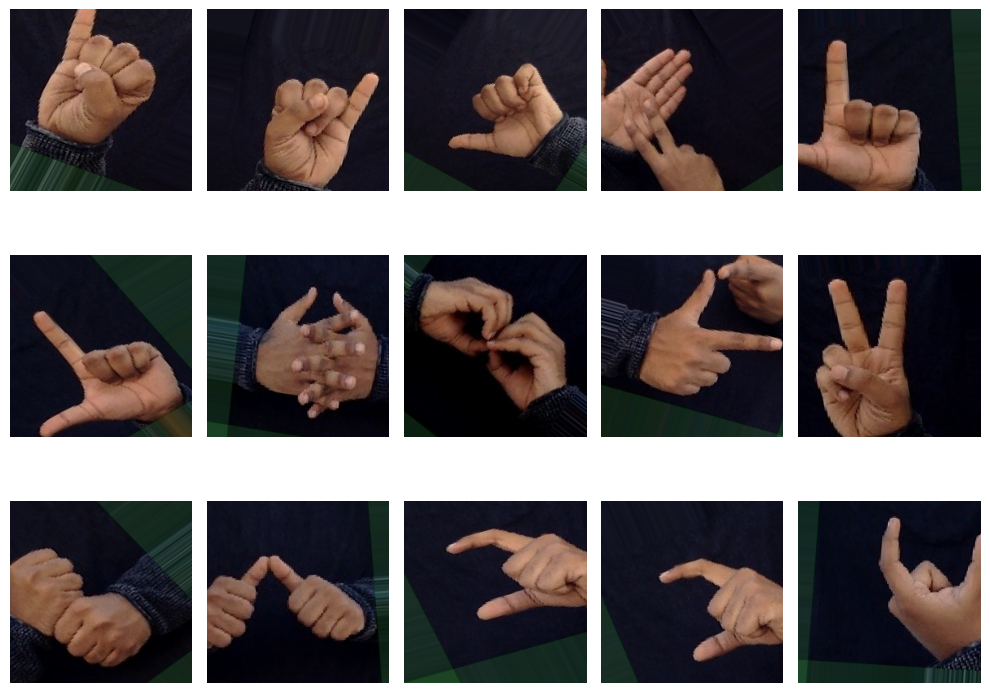

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# Create plot function
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 5, figsize=(10, 8))  # 3 rows, 5 columns
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Print images & labels
plotImages(imgs)
print(labels)

# 🔧 Build MobileNet Model

In [9]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [11]:
# Create function for count_params
def count_params(model):
    """Count the total number of trainable and non-trainable parameters in the model."""
    non_trainable_params = sum(v.shape.num_elements() for v in model.non_trainable_weights)
    trainable_params = sum(v.shape.num_elements() for v in model.trainable_weights)
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

# Call the function to get the counts
params = count_params(mobile)

# Print the counts
print("Total trainable parameters:", params['trainable_params'])
print("Total non-trainable parameters:", params['non_trainable_params'])

Total trainable parameters: 4231976
Total non-trainable parameters: 21888


In [12]:
# Add custom classification layers on top of MobileNet
x = mobile.layers[-2].output
output = Dense(units=35, activation='softmax')(x) 

In [13]:
model = Model(inputs=mobile.input, outputs=output)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,288,899 (16.36 MB)

 Trainable params: 4,267,011 (16.28 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [15]:
# Freeze layers in the base model except the last 23 layers
for layer in model.layers[:-23]:
    layer.trainable = False

# 🧰 Compile the model

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 🚂 Train the model

In [17]:
# Train the model
model.fit(x=train_generator, validation_data=valid_generator, epochs=5, verbose=2)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 - 122s - 1s/step - accuracy: 0.8046 - loss: 0.9404 - val_accuracy: 0.7829 - val_loss: 0.8253
Epoch 2/5
88/88 - 113s - 1s/step - accuracy: 0.9946 - loss: 0.0262 - val_accuracy: 1.0000 - val_loss: 0.0136
Epoch 3/5
88/88 - 142s - 2s/step - accuracy: 0.9993 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 4/5
88/88 - 142s - 2s/step - accuracy: 0.9993 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 5/5
88/88 - 115s - 1s/step - accuracy: 0.9982 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 5.5363e-04


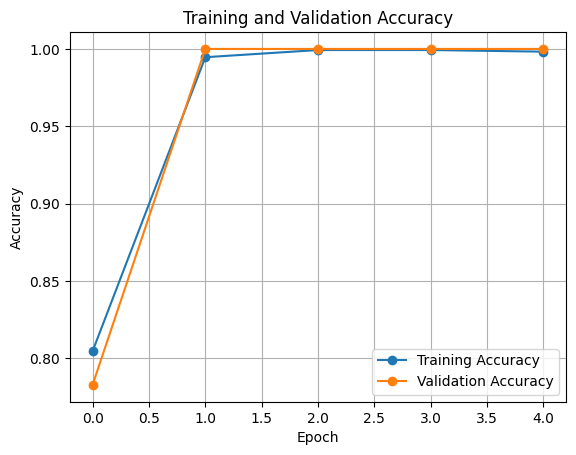

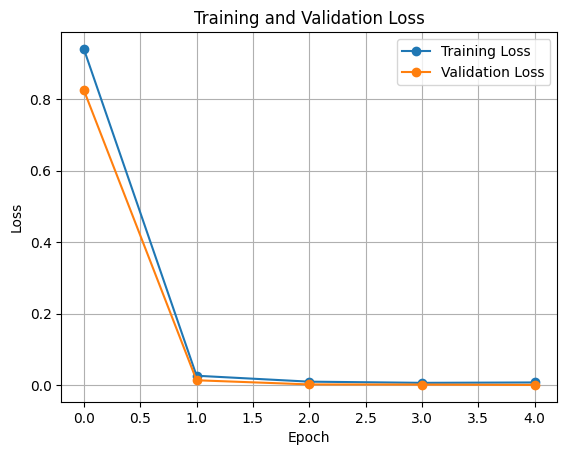

In [18]:
# Get training history
history = model.history.history

# Plot training and validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 🧪 Predict Test Data  

In [19]:
# Get the class indices from the test generator
test_labels = test_generator.classes

# Print the class indices with a gap between each class
print("Test Labels:")
for label in test_labels:
    print(label, end=" ") 
print()  # Print a newline at the end

Test Labels:
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 34 34 


In [20]:
# Make predictions on the test data
predictions = model.predict(x= test_generator, verbose=0)

In [21]:
# Calculate confusion matrix
cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))

# 📈 Evaluation

Confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 [0 1 0 ... 1 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 2 0]]


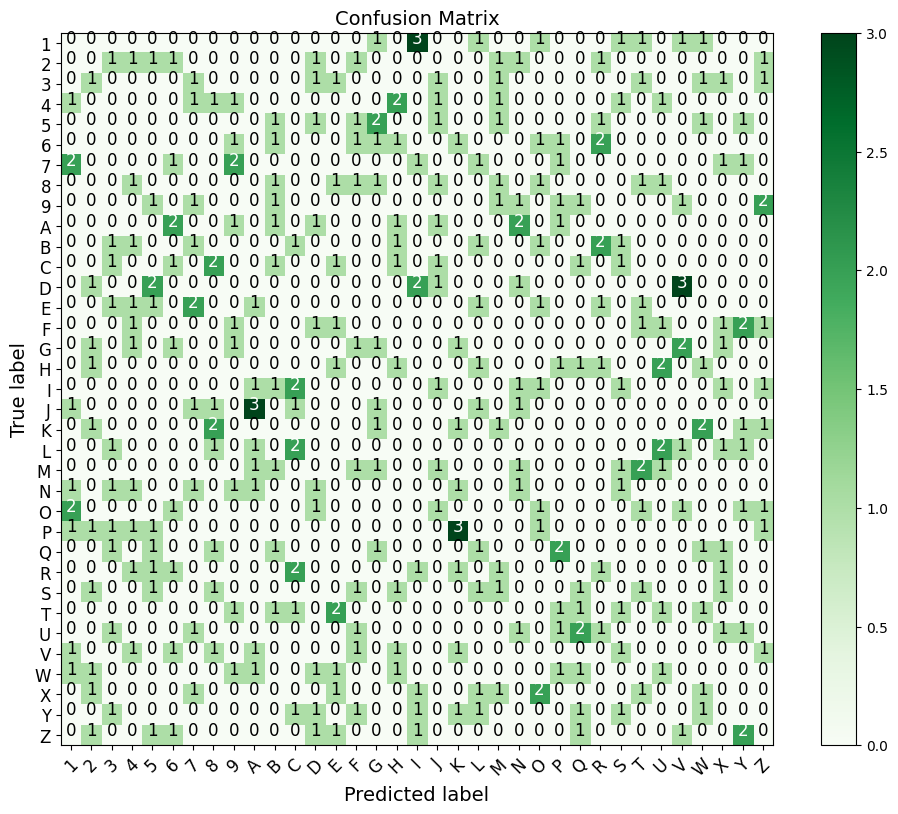

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(10, 8),
                          fontsize=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize+2)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=fontsize+2)
    plt.xlabel('Predicted label', fontsize=fontsize+2)
 
import string

# Example confusion matrix plot labels
cm_plot_labels = ['1','2', '3', '4', '5', '6', '7', '8', '9'] + list(string.ascii_uppercase)[:26]  # Adjust according to your needs


plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', cmap=plt.cm.Greens)